In [1]:
#import os
#import sys
#import glob
import numpy as np
#import pandas as pd
#import operator as op
#import itertools as it
import scipy.linalg as la
from pandas import DataFrame, Series
#from functools import reduce, partial
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("notebook", font_scale=1.5)

In [2]:
def testdata(n, k):
    """
    Make test dataset of 'n' points in 'k' concentric spirals in R^2
    """
    clus = np.random.randint(0, k, n)  # Cluster ID
    theta = np.random.uniform(0, np.sqrt(n / k**3), n) + 1  # Angle/radius
    xs = k * theta * np.cos(theta + 2 * np.pi * clus / k) + np.random.normal(0, np.pi/4, n)
    ys = k * theta * np.sin(theta + 2 * np.pi * clus / k) + np.random.normal(0, np.pi/4, n)
    return (np.column_stack([xs, ys]), clus)

In [3]:
def affinmat(pts, sigma=1):
    """
    Make scaled affinity matrix for points 'pts' using bandwidth 'sigma'
    """
    A0 = np.sum((pts[None, :] - pts[:, None])**2, -1)  # Squared distance matrix
    A = np.exp(-A0 / (2 * sigma**2))
    np.fill_diagonal(A, 0)  # Affinity matrix
    D12 = np.diag(1 / np.sqrt(np.sum(A, 1)))  # Row sums^(-1/2) for scaling
    return np.dot(np.dot(D12, A), D12)  # Scaled affinity matrix

In [4]:
def eigenmat(L, k=2):
    """
    Make scaled matrix of 'k' largest eigenvectors of scaled affinity matrix 'L'
    """
    n = L.shape[0]  # Number of points
    X = la.eigh(L, eigvals=(n - k, n - 1))[1][:, ::-1]  # k largest eigenvectors
    X1 = la.norm(X, axis=1)[:, None]  # Row norms for scaling
    return X / X1  # Scaled matrix of eigenvectors

In [5]:
def specprep(pts, k=2, sigma=1):
    """
    Prepare data for spectral clustering: convert points 'pts' into scaled
    matrix of 'k' largest eigenvectors of scaled affinity matrix with
    bandwidth 'sigma', ready for clustering by any method, e.g., k-means
    """
    L = affinmat(pts, sigma)  # Scaled affinity matrix
    Y = eigenmat(L, k)  # Scaled matix of k largest eigenvectors
    return(Y)

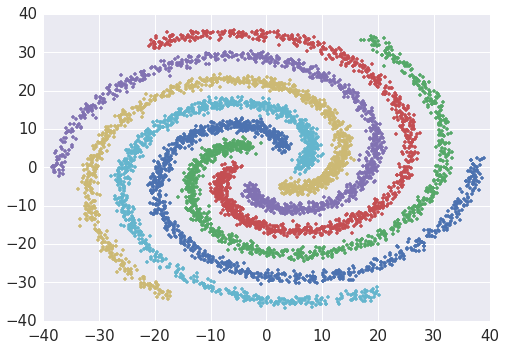

In [6]:
#### Create test dataset ####
n = 6144
k = 6
pts, clus = testdata(n, k)

#### Plot test dataset ####
for c in range(k):
    pc = np.array([pts[i] for i in range(n) if clus[i]==c])
    plt.plot(pc[:,0], pc[:,1], '.')
plt.show()

In [7]:
#### Time 'specprep' on test dataset ####
%time Y = specprep(pts, k, np.pi/4)

CPU times: user 2min 49s, sys: 7.62 s, total: 2min 57s
Wall time: 47.2 s


/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


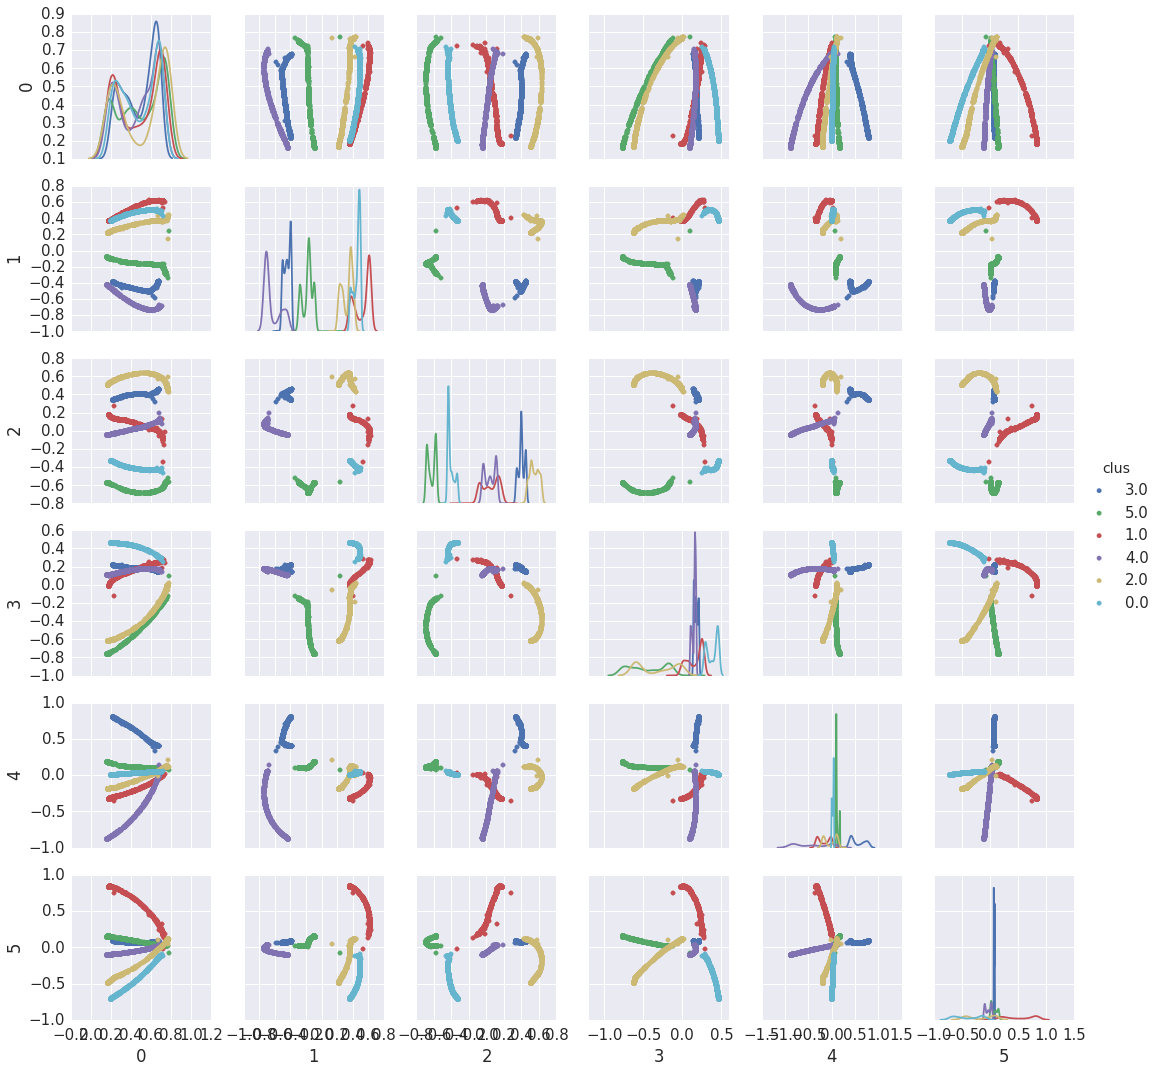

In [8]:
##### Plot first 2 dimensions to see transformed clusters ####
#for c in range(k):
#    Yc = np.array([Y[i] for i in range(n) if clus[i]==c])
#    plt.plot(Yc[:,0], Yc[:,1], '.')
#plt.show()

##### Plot first 3 dimensions to see transformed clusters ####
#from mpl_toolkits.mplot3d import Axes3D
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#Axes3D.scatter(ax, xs=Y[:,0], ys=Y[:, 1], zs=Y[:,2], c=clus)

#### Plot pairwise scatter plots to see transformed clusters ####
df = DataFrame(data=np.column_stack([Y, clus]), columns=list(range(k))+["clus"])
sns.pairplot(df, hue="clus", vars=df.columns[:-1], diag_kind="kde")
pass

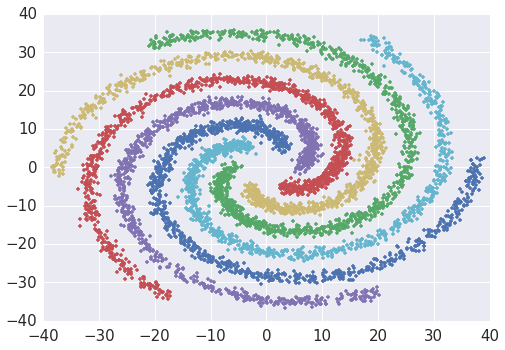

In [9]:
#### Try out K-Means on transformed data (separate from K-Means++ part of project) ####
from sklearn.cluster import KMeans
km = KMeans(n_clusters=k, n_jobs=-1)
kmcl = km.fit_predict(Y)
for c in range(k):
    pc = np.array([pts[i] for i in range(n) if kmcl[i]==c])
    plt.plot(pc[:,0], pc[:,1], '.')
plt.show()